<a href="https://colab.research.google.com/github/ryskks/usedicom/blob/main/slice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 複数のスライス画像を扱う

In [1]:
# Google Drive のマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 必要なパッケージのインストール
!pip install pydicom
!pip install matplotlib
!pip install -U python-gdcm
!pip install pylibjpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 61.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# 必要モジュールの導入
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import sys
import glob

In [4]:
# DICOM ファイルの読み込み
DIR = "/content/drive/MyDrive/Colab Notebooks/DICOM/EX1/SE1/IMG1"
d = pydicom.read_file(DIR)
# 読み込んだ変数の表示
print(d.Modality)

CT


## まずはスキャノ画像を表示します

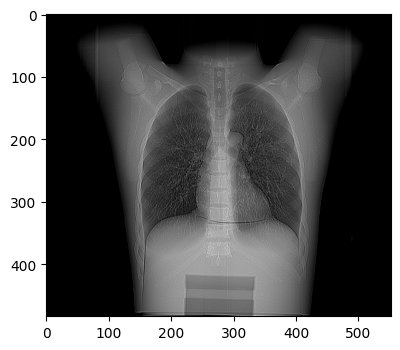

In [5]:
# 画像データを変数に代入
img = d.pixel_array

# ウィンドウレベルと幅の情報を DICOM から取得
wl = d.WindowCenter
ww = d.WindowWidth

max = wl + ww /2
min = wl - ww /2
img = 255 * (img - min) / (max - min)
img[img > 255] = 255
img[img < 0] = 0

# 表示サイズを変更
fig = plt.figure(dpi=100)
plt.imshow(img, cmap='gray')
plt.show()

## 複数のスライズ画像の読み込み

In [6]:
# DICOM ファイルを読み込み
# 空のリストを作成し，ここに画像を入れてきます
files = []
print('DICOMファイルの場所: {}'.format("/content/drive/MyDrive/Colab Notebooks/DICOM/EX1/SE2/*"))
for fname in glob.glob("/content/drive/MyDrive/Colab Notebooks/DICOM/EX1/SE2/*", recursive=False):
    files.append(pydicom.dcmread(fname))

DICOMファイルの場所: /content/drive/MyDrive/Colab Notebooks/DICOM/EX1/SE2/*


In [7]:
# slices というリストを作成
# DICOMファイルに slicelocation という属性があれば追加していく
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("ファイル数: {}".format(len(slices)))
print("スライス位置がないファイル: {}".format(skipcount))

# スライスの順番をそろえる
# SliceLocation で場所情報を取得
# Feet First で撮影しているの逆順にソート
slices = sorted(slices, key=lambda s: s.SliceLocation, reverse=True) 

ファイル数: 436
スライス位置がないファイル: 0


In [8]:
# アスペクト比を計算する
ps = slices[0].PixelSpacing    # 1ピクセルの [y, x] 長さ
ss = slices[0].SliceThickness  # スライス厚み
ax_aspect = ps[0]/ps[1]        # yの長さ/xの長さ
sag_aspect = ss/ps[0]          # スライスの厚み/y軸方向への１ピクセルの長さ 
cor_aspect = ss/ps[1]          # スライスの厚み/x軸方向への１ピクセルの長さ 

print(ps, ss, ax_aspect, cor_aspect)

[0.781, 0.781] 1.0 1.0 1.2804097311139564


In [9]:
# 空の3Dのnumpy arrayを作成する 
img_shape = list(slices[0].pixel_array.shape)
img_shape.insert(0,len(slices))   
# 空のarrayを作る
img3d = np.zeros(img_shape) 

# 3Dのnumpy arrayを作る
for i, s in enumerate(slices):
    img2d = s.pixel_array    
    img3d[i,:, :] = img2d    

## Axial 画像の観察

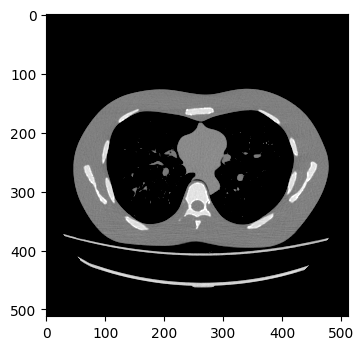

In [10]:
# 表示サイズを大きくしています
fig = plt.figure(dpi=100)

# k の値を変更するとスライス断面が変更される変更される

k = 200
plt.imshow(img3d[k, :, :], cmap='gray', vmin = -500, vmax = 500)

plt.show()

## インタラクティブに画像を観察します

In [11]:
from ipywidgets import interact

sl = len(slices)
    
def f(k):
    # 表示サイズを大きくしています
    fig = plt.figure(dpi=100)
    a1 = plt.subplot(1, 1, 1)
    plt.imshow(img3d[k, :, :], cmap='gray', vmin = -500, vmax = 500)
    a1.set_aspect(ax_aspect)
interact(f, k=(0, sl-1) )

plt.show()

interactive(children=(IntSlider(value=217, description='k', max=435), Output()), _dom_classes=('widget-interac…

複数のスライスを観察すると，多軸方向でのつながりが観察できるので，よし診断に有用であることが理解できます